# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.linalg as sl
import warnings
warnings.filterwarnings("ignore")

## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
replace ml-100k/allbut.pl? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [9]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            # select the row for user
            # what's the shape of userVector
            userVector = train_matrix[user, :]
            
            # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
            # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
                
            # report progress every 400 users
            if (user % 400 == 0 and item == 1):
                print ("calculated %d users" % (user,))
        
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        predictionMatrix = np.zeros((num_users, num_items))
        
        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
        
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range(num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
        
        for (user,item), rating in np.ndenumerate(train_matrix):
            # Predict rating for every item that wasn't ranked by the user (rating == 0)
            predictionMatrix[user, item] = itemPopularity[item]
                
            # report progress every 400 users
            if (user % 400 == 0 and item == 1):
                print ("calculated %d users" % (user,))
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [12]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 400 users
calculated 800 users


In [0]:
x = popularity_recsys.getModel()

In [14]:
np.all(x<=1)

True

In [15]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:32, 1085.94it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [18]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 400 users
calculated 800 users


In [19]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [20]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:31, 1096.38it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        corr_distance = pairwise_distances(matrix, metric='correlation')
        similarity_matrix = 1/(1+np.sqrt(corr_distance))
        
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5   
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #Cold start
            # if no one has rated this item before, use user average  
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########

        elif self.base == 'item':
            ########### your code goes here ###########
            train_matrix=train_matrix.T
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = self.method(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5 
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix.T
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [22]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [24]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.44948974, 0.44948974],
       [0.44948974, 1.        , 0.44948974],
       [0.44948974, 0.44948974, 1.        ]])

Cosine similarity works better than euclidean similarity, because euclidean similarity is distance-based while cosine similarity normalizes the distance.

### (b)

Correlation is good for calculating similarity metric because it is invariant to scaling and also to adding any constant to all elements.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [27]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [28]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [29]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:44, 955.92it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [30]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [31]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:31, 1087.81it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
cv_patk = CrossValidation('RMSE')

In [36]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
cv_patk.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:11, 1719.44it/s]
20000it [00:11, 1709.09it/s]
20000it [00:11, 1721.92it/s]
20000it [00:11, 1726.61it/s]
20000it [00:11, 1712.11it/s]


Processing algorithm user-cosine


20000it [00:11, 1726.61it/s]
20000it [00:11, 1744.39it/s]
20000it [00:11, 1734.59it/s]
20000it [00:11, 1740.21it/s]
20000it [00:11, 1741.12it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

In [82]:
user_rating_count=rating_df.drop(['timestamp','itemID'],axis=1)
user_rating_count=user_rating_count.groupby('userID')['rating'].count().reset_index()
item_rating_count=rating_df.drop(['timestamp','userID'],axis=1)
item_rating_count=item_rating_count.groupby('itemID')['rating'].count().reset_index()
print(user_rating_count['rating'].describe())
print(item_rating_count['rating'].describe())

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64
count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64


user-user similarity RMSE performs a little bit better than item-item cosine similarity. The reason is that the average number of ratings per user is higher than the average number of ratings per item, so there are less zero when comparing two users' ratings than two items' ratings.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = 0.1*np.random.randn(num_item,self.num_feat)  # item M x D 
        self.w_User = 0.1*np.random.randn(num_user,self.num_feat)   # user N x D 
    
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
                
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID,:],self.w_Item[batch_ItemID,:]),axis=1) #size (batch_size, )
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]
  
                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx,:],self.w_Item[train_item_idx,:]),axis=1)
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx,:],self.w_Item[val_item_idx,:]),axis=1) #size(pairs_val, )
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 100, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

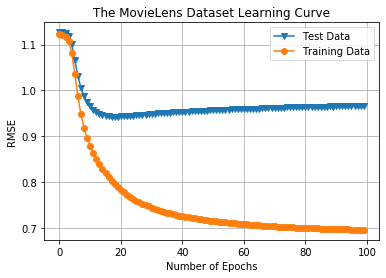

In [39]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

The best maxepoch is 20, because after 20 epoches, the test data RMSE do not change while the training data RMSE is getting smaller. To avoid overfitting ,the maxepoch should set to 20.

In [0]:
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})

## Q5

### (a)

In [0]:
algorithm_instances_Q5 = [popularity_recsys,
                          average_user_rating_recsys,
                          user_cosine_recsys, 
                          item_cosine_recsys,
                          pmf]

In [0]:
eval_metrics=['RMSE','P@K','R@K']

In [43]:
result_list=[]
for metric in eval_metrics:
  cv_patk = CrossValidation(metric)
  result=cv_patk.run(algorithm_instances_Q5, num_users, num_items,k=5)
  result_list.append(result)

Processing algorithm popularity
calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1680.77it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1708.03it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1735.85it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1720.43it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1728.02it/s]


Processing algorithm useraverage
calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1724.42it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1721.22it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1704.42it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1700.18it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1714.84it/s]


Processing algorithm user-cosine


20000it [00:11, 1701.74it/s]
20000it [00:11, 1720.07it/s]
20000it [00:11, 1707.62it/s]
20000it [00:11, 1729.81it/s]
20000it [00:11, 1687.61it/s]


Processing algorithm item-cosine


20000it [00:11, 1680.69it/s]
20000it [00:11, 1696.66it/s]
20000it [00:11, 1711.46it/s]
20000it [00:11, 1702.85it/s]
20000it [00:11, 1719.98it/s]


Processing algorithm PMF


20000it [00:18, 1092.80it/s]
20000it [00:18, 1078.48it/s]
20000it [00:18, 1091.79it/s]
20000it [00:18, 1090.04it/s]
20000it [00:18, 1092.09it/s]


Processing algorithm popularity
calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1698.93it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1716.27it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1736.96it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1733.75it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1733.43it/s]


Processing algorithm useraverage
calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1703.99it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1717.79it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1737.23it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1736.75it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1721.34it/s]


Processing algorithm user-cosine


20000it [00:11, 1727.12it/s]
20000it [00:11, 1720.69it/s]
20000it [00:11, 1719.88it/s]
20000it [00:11, 1734.58it/s]
20000it [00:11, 1727.31it/s]


Processing algorithm item-cosine


20000it [00:11, 1728.23it/s]
20000it [00:11, 1724.06it/s]
20000it [00:11, 1719.15it/s]
20000it [00:11, 1713.48it/s]
20000it [00:11, 1737.78it/s]


Processing algorithm PMF


20000it [00:18, 1072.69it/s]
20000it [00:18, 1083.37it/s]
20000it [00:18, 1071.96it/s]
20000it [00:18, 1092.75it/s]
20000it [00:18, 1085.79it/s]


Processing algorithm popularity
calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1709.56it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1702.52it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1705.47it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1726.98it/s]


calculated 0 users
calculated 400 users


0it [00:00, ?it/s]

calculated 800 users


20000it [00:11, 1699.62it/s]


Processing algorithm useraverage
calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1735.88it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1695.05it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1715.19it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1713.52it/s]


calculated 0 users
calculated 400 users
calculated 800 users


20000it [00:11, 1705.91it/s]


Processing algorithm user-cosine


20000it [00:11, 1684.71it/s]
20000it [00:11, 1680.89it/s]
20000it [00:11, 1684.77it/s]
20000it [00:11, 1685.77it/s]
20000it [00:11, 1702.10it/s]


Processing algorithm item-cosine


20000it [00:11, 1690.41it/s]
20000it [00:11, 1686.01it/s]
20000it [00:11, 1695.24it/s]
20000it [00:11, 1684.72it/s]
20000it [00:11, 1709.73it/s]


Processing algorithm PMF


20000it [00:18, 1060.89it/s]
20000it [00:19, 1046.80it/s]
20000it [00:18, 1058.59it/s]
20000it [00:19, 1052.04it/s]
20000it [00:19, 1045.67it/s]


In [0]:
recommenders=list(result_list[0].keys())
score_list=[]
for i in range(3):
  metric_list=[]
  for re in recommenders:
    avg_score=round(result_list[i][re][1],4)
    metric_list.append(avg_score)
  score_list.append(metric_list)

In [45]:
d={"method":recommenders,"RMSE":score_list[0],"P@K":score_list[1],"R@K":score_list[2]}
df=pd.DataFrame(d)
df=df.set_index('method')
df

,RMSE,P@K,R@K
method,,,
popularity,3.1591,0.5506,0.4841
useraverage,1.0437,0.4736,0.4413
user-cosine,1.0174,0.5558,0.4863
item-cosine,1.0201,0.5322,0.4750
PMF,0.9401,0.5577,0.4861


### (b)

Popularity based recommendation cannot be evaluated by RMSE because popularity is defined as #userliked/# userrated. Its value range is [0,1], which is smaller than ground truth rating range [1,5], so popularity should be evaluated by ranking metrics not by RMSE.

### (c)

PMF is the best algorithm for RMSE, ,P@K and R@K. PMF is designed to minimize the mean squared error between ratings and predictions, and when the RMSE is minimized, the error of the ranking of prediction ratings is also get minimized.



### (d)

Good performance on RMSE implies good performance on ranking metrics, but it's not vice versa. Because in ranking metrics, ther is no need for normalization. Even with large RMSE, some method can still rank the ratings correctly.

## Q6

### (a)

In [46]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [47]:
movie_names=moviesDF['movieTitle'].values
movies_sim=pd.DataFrame(SimBasedRecSys.cosine(dataPreprocessor(rating_df, num_users, num_items).T),columns=movie_names,index=movie_names)
movies_sim.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),Seven (Se7en) (1995),"Usual Suspects, The (1995)",Mighty Aphrodite (1995),"Postino, Il (1994)",Mr. Holland's Opus (1995),French Twist (Gazon maudit) (1995),From Dusk Till Dawn (1996),"White Balloon, The (1995)",Antonia's Line (1995),Angels and Insects (1995),Muppet Treasure Island (1996),Braveheart (1995),Taxi Driver (1976),Rumble in the Bronx (1995),"Birdcage, The (1996)","Brothers McMullen, The (1995)",Bad Boys (1995),Apollo 13 (1995),Batman Forever (1995),Belle de jour (1967),Crimson Tide (1995),Crumb (1994),Desperado (1995),"Doom Generation, The (1995)",Free Willy 2: The Adventure Home (1995),Mad Love (1995),Nadja (1994),"Net, The (1995)",Strange Days (1995),"To Wong Foo, Thanks for Everything! Julie Newmar (1995)",...,Angel Baby (1995),Sudden Manhattan (1996),"Butcher Boy, The (1998)",Men With Guns (1997),Hana-bi (1997),"Niagara, Niagara (1997)","Big One, The (1997)","Butcher Boy, The (1998)","Spanish Prisoner, The (1997)",Temptress Moon (Feng Yue) (1996),Entertaining Angels: The Dorothy Day Story (1996),Chairman of the Board (1998),"Favor, The (1994)",Little City (1998),Target (1995),"Substance of Fire, The (1996)",Getting Away With Murder (1996),Small Faces (1995),"New Age, The (1994)",Rough Magic (1995),Nothing Personal (1995),8 Heads in a Duffel Bag (1997),"Brother's Kiss, A (1997)",Ripe (1996),"Next Step, The (1995)",Wedding Bell Blues (1996),MURDER and murder (1996),Tainted (1998),"Further Gesture, A (1996)",Kika (1993),Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
Toy Story (1995),1.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,0.468291,0.460392,0.417509,0.347678,0.574377,0.224120,0.273916,0.046232,0.191772,0.232930,0.339196,0.527169,0.338105,0.467598,0.567950,0.227295,0.208472,0.592877,0.361657,0.150959,0.439441,0.259257,0.288536,0.090654,0.136757,0.108560,0.069805,0.368420,0.278386,0.246123,...,0.065390,0.010550,0.023592,0.014155,0.023592,0.023592,0.023592,0.023592,0.023592,0.014226,0.0,0.058979,0.047183,0.032856,0.035387,0.048189,0.058979,0.058979,0.035387,0.0,0.0,0.067404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033363,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
GoldenEye (1995),0.402382,1.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,0.468506,0.459946,0.213972,0.125463,0.253162,0.098185,0.390438,0.113063,0.030692,0.091550,0.319308,0.483349,0.278182,0.434907,0.306639,0.206481,0.408737,0.483077,0.581119,0.089355,0.462797,0.160738,0.479187,0.072342,0.087347,0.215247,0.184592,0.562970,0.334570,0.256668,...,0.049324,0.035017,0.078299,0.046980,0.078299,0.078299,0.078299,0.078299,0.078299,0.000000,0.0,0.000000,0.078299,0.000000,0.104399,0.000000,0.000000,0.000000,0.104399,0.0,0.0,0.074571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.055366,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
Four Rooms (1995),0.330245,0.273069,1.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,0.361165,0.319295,0.271402,0.190242,0.266335,0.167609,0.404239,0.126564,0.105377,0.187733,0.194546,0.293732,0.233814,0.381910,0.306447,0.214125,0.261303,0.269296,0.253074,0.126347,0.259129,0.185187,0.404930,0.179008,0.046315,0.073332,0.051270,0.240534,0.277311,0.176729,...,0.036615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009736,0.0,0.000000,0.096875,0.000000,0.000000,0.000000,0.064583,0.064583,0.096875,0.0,0.0,0.018452,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
Get Shorty (1995),0.454938,0.502571,0.324866,1.000000,0.334239,0.090308,0.489283,0.490236,0.41

In [0]:
movie_chosen=['Sleepless in Seattle (1993)',
              'Waiting for Guffman (1996)',
              "Aladdin (1992)"]

In [83]:
dic_movie={}
for movie in movie_chosen:
  print("The top 5 most similar movies to {} are:".format(movie))
  dic_movie[movie]=list(movies_sim[movie].sort_values(ascending=False)[:6].index)
  print(movies_sim[movie].sort_values(ascending=False)[1:6])
  print('\n')

The top 5 most similar movies to Sleepless in Seattle (1993) are:
While You Were Sleeping (1995)    0.682382
Mrs. Doubtfire (1993)             0.676511
Groundhog Day (1993)              0.670296
When Harry Met Sally... (1989)    0.660843
Dave (1993)                       0.648957
Name: Sleepless in Seattle (1993), dtype: float64


The top 5 most similar movies to Waiting for Guffman (1996) are:
Welcome to the Dollhouse (1995)    0.366873
Grosse Pointe Blank (1997)         0.330767
Shall We Dance? (1996)             0.329216
Donnie Brasco (1997)               0.321798
Flirt (1995)                       0.312998
Name: Waiting for Guffman (1996), dtype: float64


The top 5 most similar movies to Aladdin (1992) are:
Lion King, The (1994)              0.753162
Beauty and the Beast (1991)        0.723811
Jurassic Park (1993)               0.670658
Back to the Future (1985)          0.665898
Empire Strikes Back, The (1980)    0.632218
Name: Aladdin (1992), dtype: float64




### (b)

We can justify these similarities through the genre columns. "Sleepless in Seattle" and its most similar movies are all comedy and romance movies. And the top 3 similar movies to "Waiting for Guffman (1996)" have the same genre : comedy. As for Aladdin (1992), it and its similar movies "The Lion King" and "Beauty and the Beast
" are all Disney movies, and they are all musical, animation and children movies.

In [84]:
moviesDF[moviesDF['movieTitle'].isin(dic_movie[movie_chosen[0]])]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
65,66,While You Were Sleeping (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?While%20You%2...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
87,88,Sleepless in Seattle (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sleepless%20i...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
201,202,Groundhog Day (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Groundhog%20D...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
215,216,When Harry Met Sally... (1989),01-Jan-1989,NaN,http://us.imdb.com/M/title-exact?When%20Harry%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
392,393,Mrs. Doubtfire (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Mrs.%20Doubtf...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
731,732,Dave (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Dave%20(1993),0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [85]:
moviesDF[moviesDF['movieTitle'].isin(dic_movie[movie_chosen[1]])]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
92,93,Welcome to the Dollhouse (1995),24-May-1996,NaN,http://us.imdb.com/Title?Welcome+to+the+Dollho...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
247,248,Grosse Pointe Blank (1997),11-Apr-1997,NaN,http://us.imdb.com/M/title-exact?Grosse%20Poin...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
250,251,Shall We Dance? (1996),11-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Shall%20we%20...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
292,293,Donnie Brasco (1997),28-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Donnie%20Bras...,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
1006,1007,Waiting for Guffman (1996),31-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Waiting%20for...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1494,1495,Flirt (1995),07-Aug-1996,NaN,http://us.imdb.com/Title?Flirt+(1995/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [86]:
moviesDF[moviesDF['movieTitle'].isin(dic_movie[movie_chosen[2]])]

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
70,71,"Lion King, The (1994)",01-Jan-1994,NaN,"http://us.imdb.com/M/title-exact?Lion%20King,%...",0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
81,82,Jurassic Park (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Jurassic%20Pa...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
94,95,Aladdin (1992),01-Jan-1992,NaN,http://us.imdb.com/M/title-exact?Aladdin%20(1992),0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,NaN,http://us.imdb.com/M/title-exact?Empire%20Stri...,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0
203,204,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
587,588,Beauty and the Beast (1991),01-Jan-1991,NaN,http://us.imdb.com/M/title-exact?Beauty%20and%...,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


## Q7

### (a)

In [53]:
rating_count=rating_df.drop(['timestamp','itemID'],axis=1)
rating_count=rating_count.groupby('userID')['rating'].count().reset_index()
rating_count.head()

,userID,rating
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


Text(0, 0.5, 'number of users')

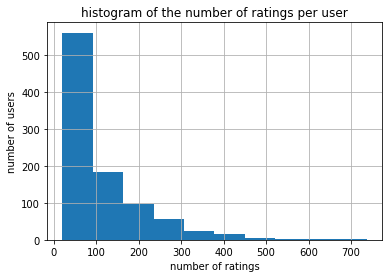

In [54]:
rating_count['rating'].hist()
plt.title("histogram of the number of ratings per user")
plt.xlabel('number of ratings')
plt.ylabel('number of users')

In [0]:
threshold = 100

In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
def divide_df(dataframe, threshold):
  above_df=dataframe[dataframe['userID'].isin(list(rating_count[rating_count['rating']>=threshold]['userID']))].reset_index(drop=True)
  below_df=dataframe[dataframe['userID'].isin(list(rating_count[rating_count['rating']<threshold]['userID']))].reset_index(drop=True)
  return above_df,below_df

In [0]:
def compare_threshold(trainfile,testfile,threshold):
  ubase_df = getData(MOVIELENS_DIR, trainfile)
  utest_df = getData(MOVIELENS_DIR, testfile)
  ubase_above,ubase_below=divide_df(ubase_df,threshold)
  utest_above,utest_below=divide_df(utest_df,threshold)
 
  # u-u above
  above_testMatrix=dataPreprocessor(utest_above, num_users, num_items)
  user_cosine_recsys.predict_all(ubase_above, num_users, num_items)
  user_above_predMatrix=user_cosine_recsys.getModel()

  # u-u below
  below_testMatrix=dataPreprocessor(utest_below, num_users, num_items)
  user_cosine_recsys.predict_all(ubase_below, num_users, num_items)
  user_below_predMatrix=user_cosine_recsys.getModel()

  # i-i above
  item_cosine_recsys.predict_all(ubase_above, num_users, num_items)
  item_above_predMatrix=item_cosine_recsys.getModel()

  # i-i below
  item_cosine_recsys.predict_all(ubase_below, num_users, num_items)
  item_below_predMatrix=item_cosine_recsys.getModel()

  # rmse 
  user_above_rmse=rmse(user_above_predMatrix, above_testMatrix)
  user_below_rmse=rmse(user_below_predMatrix, below_testMatrix)
  item_above_rmse=rmse(item_above_predMatrix, above_testMatrix)
  item_below_rmse=rmse(item_below_predMatrix, below_testMatrix)
  
  # print
  dash = '-' * 40
  print(dash)
  print(testfile)
  print(dash)
  print('{:<10s}{:>4s}{:>12s}'.format('','Hight','Low'))
  print('{:<10s}{:>4.5f}{:>12.5f}'.format('User',round(user_above_rmse,5),round(user_below_rmse,5)))
  print('{:<10s}{:>4.5f}{:>12.5f}'.format('Item',round(item_above_rmse,5),round(item_below_rmse,5)))

In [59]:
compare_threshold('u1.base','u1.test',100)
compare_threshold('u2.base','u2.test',100)
compare_threshold('u3.base','u3.test',100)
compare_threshold('u4.base','u4.test',100)
compare_threshold('u5.base','u5.test',100)

----------------------------------------
u1.test
----------------------------------------
          Hight         Low
User      1.02406     1.06051
Item      1.04418     1.11251
----------------------------------------
u2.test
----------------------------------------
          Hight         Low
User      1.01414     1.08172
Item      1.02435     1.08382
----------------------------------------
u3.test
----------------------------------------
          Hight         Low
User      1.00768     1.06731
Item      1.00414     1.09182
----------------------------------------
u4.test
----------------------------------------
          Hight         Low
User      1.00217     1.07196
Item      1.00997     1.09298
----------------------------------------
u5.test
----------------------------------------
          Hight         Low
User      1.01403     1.06282
Item      1.02452     1.07319


The RMSE performances of above threshold are better than that of below threshold. Because there are more samples for each user above the threshold, and therefore each item has more rating information, so the prediction will be more precise.


# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [68]:
validatePopularityRecSys()

calculated 0 users
calculated 400 users
calculated 800 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [70]:
validateUserAverRecSys()

calculated 0 users
calculated 400 users
calculated 800 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)